##### Import required packages  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore',DeprecationWarning)
import seaborn as sns
import time
#import hdbscan

from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

#from sklearn.datasets import make_blobs

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn import metrics as mt
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix as conf
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

from tabulate import tabulate

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Read in dataset from .csv file  

In [2]:
data_dir = '../data/'
data_file = 'OnlineNewsPopularity.csv'

file_2_read = data_dir + data_file
df = pd.read_csv(file_2_read)  

In [3]:
df.columns = df.columns.str.strip()
col_names = df.columns.values.tolist()

col_names

['url',
 'timedelta',
 'n_tokens_title',
 'n_tokens_content',
 'n_unique_tokens',
 'n_non_stop_words',
 'n_non_stop_unique_tokens',
 'num_hrefs',
 'num_self_hrefs',
 'num_imgs',
 'num_videos',
 'average_token_length',
 'num_keywords',
 'data_channel_is_lifestyle',
 'data_channel_is_entertainment',
 'data_channel_is_bus',
 'data_channel_is_socmed',
 'data_channel_is_tech',
 'data_channel_is_world',
 'kw_min_min',
 'kw_max_min',
 'kw_avg_min',
 'kw_min_max',
 'kw_max_max',
 'kw_avg_max',
 'kw_min_avg',
 'kw_max_avg',
 'kw_avg_avg',
 'self_reference_min_shares',
 'self_reference_max_shares',
 'self_reference_avg_sharess',
 'weekday_is_monday',
 'weekday_is_tuesday',
 'weekday_is_wednesday',
 'weekday_is_thursday',
 'weekday_is_friday',
 'weekday_is_saturday',
 'weekday_is_sunday',
 'is_weekend',
 'LDA_00',
 'LDA_01',
 'LDA_02',
 'LDA_03',
 'LDA_04',
 'global_subjectivity',
 'global_sentiment_polarity',
 'global_rate_positive_words',
 'global_rate_negative_words',
 'rate_positive_words',
 

# Data Preparation Part 1	
10	
Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

### Task 2 data set definition  

 - For Task 2 classification we will classify the articles according to which data channel they are most likely to belong. The business case for this is to support directing the article to the data_channel most appropriate for the article content.  
 - In order to support this classification task, we create a new dependent variable column __data_channel__  which combines all of the individual binary boolean columns of __data_channel_is_xxx__ to __data_channel__ column with appropriate value  
 - We create 2 sets of this dependent variable, __data_channel__ and __data_channel_n__ . The only difference between these 2 columns is that __data_channel__ contains the text values for data channel category while the __data_channel_n__ contains an integer classifier (1 --> 7) which we associate to the text description in alphabetic order.  We create 2 versions of the column to be able to use the text version, when feasible, and the integer version in the case that that is required for a particular classifier routine.  
 - There are approx 15% of the articles which contain no identified __data_channel__ in the original data set. We create a new category, _Others_, for the articles without assignation to one of the standard data channels.  

In [4]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... creating data_channel categorical variable
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df['data_channel'] = 'Others'

condition = df['data_channel_is_lifestyle'] == 1
df.loc[condition, 'data_channel'] = 'Lifestyle'

condition = df['data_channel_is_entertainment'] == 1
df.loc[condition, 'data_channel'] = 'Entertainment'

condition = df['data_channel_is_bus'] == 1
df.loc[condition, 'data_channel'] = 'Business'

condition = df['data_channel_is_socmed'] == 1
df.loc[condition, 'data_channel'] = 'Social Media'

condition = df['data_channel_is_tech'] == 1
df.loc[condition, 'data_channel'] = 'Technology'

condition = df['data_channel_is_world'] == 1
df.loc[condition, 'data_channel'] = 'World'

del df['data_channel_is_lifestyle']
del df['data_channel_is_entertainment']
del df['data_channel_is_bus']
del df['data_channel_is_socmed']
del df['data_channel_is_tech']
del df['data_channel_is_world']


In [5]:
df.data_channel.value_counts()

World            8427
Technology       7346
Entertainment    7057
Business         6258
Others           6134
Social Media     2323
Lifestyle        2099
Name: data_channel, dtype: int64

In [6]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... integer value of categorical values for multinomial NB classification
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df['data_channel_n'] = 0

condition = df['data_channel'] == 'Business'
df.loc[condition, 'data_channel_n'] = 1

condition = df['data_channel'] == 'Entertainment'
df.loc[condition, 'data_channel_n'] = 2

condition = df['data_channel'] == 'Lifestyle'
df.loc[condition, 'data_channel_n'] = 3

condition = df['data_channel'] == 'Others'
df.loc[condition, 'data_channel_n'] = 4

condition = df['data_channel'] == 'Social Media'
df.loc[condition, 'data_channel_n'] = 5

condition = df['data_channel'] == 'Technology'
df.loc[condition, 'data_channel_n'] = 6

condition = df['data_channel'] == 'World'
df.loc[condition, 'data_channel_n'] = 7



In [7]:
df.data_channel_n.value_counts()

7    8427
6    7346
2    7057
1    6258
4    6134
5    2323
3    2099
Name: data_channel_n, dtype: int64


#### Delete __shares__ from the Task 2 data set  

__shares__ is the Task 1 dependent variable

we are excluding it from the Task 2 dataset as per the business model this value is not available during data_channel selection

The business model being developed here is that an article is proposed for publication, a set of text processing routines will extract and develop the model features from the raw article. The next step is to deploy the __data_channel__ assignment (classification) model, which is then also a necessary ingredient for the final model, Task 1, which is to estimate the __popularity__ of the article and thus provide recommendation to publish or not to publish.

Thus, for this Task 2 data set, we exclude the __shares__ data value.


In [8]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  shares is task 1 dependent variable
# ...  we are excluding it from this model as per business model this value is not available
# ...  during data_channel prediction
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

del df['shares'] 


In [9]:
del df['n_non_stop_words']
del df['n_non_stop_unique_tokens']
del df['n_unique_tokens']
del df['url']

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
timedelta,39644.0,354.530471,214.163767,8.00000,164.000000,339.000000,542.000000,731.000000
n_tokens_title,39644.0,10.398749,2.114037,2.00000,9.000000,10.000000,12.000000,23.000000
n_tokens_content,39644.0,546.514731,471.107508,0.00000,246.000000,409.000000,716.000000,8474.000000
num_hrefs,39644.0,10.883690,11.332017,0.00000,4.000000,8.000000,14.000000,304.000000
num_self_hrefs,39644.0,3.293638,3.855141,0.00000,1.000000,3.000000,4.000000,116.000000
num_imgs,39644.0,4.544143,8.309434,0.00000,1.000000,1.000000,4.000000,128.000000
num_videos,39644.0,1.249874,4.107855,0.00000,0.000000,0.000000,1.000000,91.000000
average_token_length,39644.0,4.548239,0.844406,0.00000,4.478404,4.664082,4.854839,8.041534
num_keywords,39644.0,7.223767,1.909130,1.00000,6.000000,7.000000,9.000000,10.000000
kw_min_min,39644.0,26.106801,69.633215,-1.00000,-1.000000,-1.000000,4.000000,377.000000


#### Assign certain variables to type integer, as appropriate

In [11]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  convert the data type to Integer
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

to_int = ['timedelta','n_tokens_title', 'n_tokens_content',
    'num_hrefs','num_self_hrefs', 'num_imgs', 'num_videos', 'num_keywords',
    'weekday_is_monday',
    'weekday_is_tuesday',
    'weekday_is_wednesday',
    'weekday_is_thursday',
    'weekday_is_friday',
    'weekday_is_saturday',
    'weekday_is_sunday',
    'is_weekend',
    'data_channel_n']
    

df[to_int] = df[to_int ].astype(np.int64)

In [12]:
df[df.duplicated()]

,timedelta,n_tokens_title,n_tokens_content,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_min_min,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,data_channel,data_channel_n


#### Impute kw_avg_max for 0-values and re-scale to standard normal scale

 - A small number of rows have 0 value for __kw_avg_max__, which is completely out of range for the remaining rows of this variable.    
 - We will impute these rows to median value of the column  
 
 - The magnitude of this column of data is markedly different than the range of values in the remaining columns in the data set. To bring this back in line, we will re-scale the values in this column to standard normal range

In [13]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  impute to median value for a few rows of kw_avg_max
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df.kw_avg_max.median()

condition = df['kw_avg_max'] == 0
df.loc[condition, 'kw_avg_max'] = df.kw_avg_max.median()

df.kw_avg_max.median()


# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  scale to standard normal scale
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

#df.kw_avg_max.min()
#df.kw_avg_max.max()
#df.kw_avg_max.mean()
#df.kw_avg_max.std()

df.kw_avg_max = (df.kw_avg_max - df.kw_avg_max.mean()) / df.kw_avg_max.std()

#df.kw_avg_max.min()
#df.kw_avg_max.max()
#df.kw_avg_max.mean()
#df.kw_avg_max.std()


244572.22222250002

244575.00000025

#### Constant offset for variables with min value < 0  

 - This allows to consider these variables for ln() transform if highly right-skewed and also supports some classification models that only accept independent variables that are > 0  
 - Method here is to just add -1 * min_value of any column for which min_value < 0

In [14]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  for all columns with negative values, add +1 to all values in the column
# ...  - the only columns with negative values are polarity / sentiment measures
# ...  - adding a constant to all values does not modify distributions
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])
numeric_col_names = df_numeric.columns.values.tolist()

# ... store min value for each column

df_mins = df.min()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  loop on each column, test for min < 0, add constant as applicable
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

for column in numeric_col_names :
    if df_mins[column] < 0 :
        df[column] = df[column] - df_mins[column]
        
#        print('--> min_value < 0 adjusted : ', column, df_mins[column])

#### Ln() transform for variables that are right skewed (skewness > 1)  

 - This facilitiates maintaining more normally distributed residuals for regression models  
 - Likely, this will not be needed for the classification task, at present, but also does not have negative effects for this current activity


In [15]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  ln() transform right skewed distribution variables (skewness > 1)
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])

numeric_col_names = df_numeric.columns.values.tolist()

# ... store min value for each column

df_mins = df.min()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  loop on each column, test for skewness, create new column if conditions met
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

columns_to_drop = []

for column in numeric_col_names:
    sk = df[column].skew()
    
    if(sk > 1):
        new_col_name = 'ln_' + column
        print (column, sk, new_col_name)
        
        if df_mins[column] > 0:
            df[new_col_name] = np.log(df[column])
            columns_to_drop.append(column)
            
        elif df_mins[column] == 0:
            df_tmp = df[column] + 1
            df[new_col_name] = np.log(df_tmp)
            columns_to_drop.append(column)
            
        else:
            print('--> Ln() transform not completed -- skew > 1, but min value < 0 :', column, '!!')
            
            
# ... delete tmp data

del df_tmp
del df_mins
del df_numeric

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  based on inspection, a few of these are just not valid ranges in ln() space
# ...  -- just delete these few back out of the data set
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

print (columns_to_drop)

del df['ln_LDA_00']
del df['ln_LDA_01']
del df['ln_LDA_02']
del df['ln_LDA_03']
del df['ln_LDA_04']
columns_to_drop.remove('LDA_00')
columns_to_drop.remove('LDA_01')
columns_to_drop.remove('LDA_02')
columns_to_drop.remove('LDA_03')
columns_to_drop.remove('LDA_04')

# ...  these are binary indicators ... so no need to ln-transform

del df['ln_weekday_is_monday']
del df['ln_weekday_is_tuesday']
del df['ln_weekday_is_wednesday']
del df['ln_weekday_is_thursday']
del df['ln_weekday_is_friday']
del df['ln_weekday_is_saturday']
del df['ln_weekday_is_sunday']
del df['ln_is_weekend']
columns_to_drop.remove('is_weekend')
columns_to_drop.remove('weekday_is_monday')
columns_to_drop.remove('weekday_is_tuesday')
columns_to_drop.remove('weekday_is_wednesday')
columns_to_drop.remove('weekday_is_thursday')
columns_to_drop.remove('weekday_is_friday')
columns_to_drop.remove('weekday_is_saturday')
columns_to_drop.remove('weekday_is_sunday')

#columns_to_drop.remove('data_channel')

print ('\n-----------------------------------\n')
print ('Number of current columns in dataset :', len(df.columns))

df.drop(columns_to_drop, axis = 1, inplace = True)

#df.info()


n_tokens_content 2.94542193879 ln_n_tokens_content
num_hrefs 4.0134948282 ln_num_hrefs
num_self_hrefs 5.17275110576 ln_num_self_hrefs
num_imgs 3.94659584465 ln_num_imgs
num_videos 7.0195327863 ln_num_videos
kw_min_min 2.37494728018 ln_kw_min_min
kw_max_min 35.3284337312 ln_kw_max_min
kw_avg_min 31.3061081027 ln_kw_avg_min
kw_min_max 10.3863716348 ln_kw_min_max
kw_max_avg 16.4116695554 ln_kw_max_avg
kw_avg_avg 5.76017729162 ln_kw_avg_avg
self_reference_min_shares 26.2643641603 ln_self_reference_min_shares
self_reference_max_shares 13.8708490494 ln_self_reference_max_shares
self_reference_avg_sharess 17.9140933777 ln_self_reference_avg_sharess
weekday_is_monday 1.77590824423 ln_weekday_is_monday
weekday_is_tuesday 1.61054706191 ln_weekday_is_tuesday
weekday_is_wednesday 1.60097097689 ln_weekday_is_wednesday
weekday_is_thursday 1.6370700483 ln_weekday_is_thursday
weekday_is_friday 2.03030483518 ln_weekday_is_friday
weekday_is_saturday 3.63708575997 ln_weekday_is_saturday
weekday_is_sunday

# Data Preparation Part 2

#### Data Selection - Task 2 - data_channel classification

- There are 60 columns in the original data set; we added a few additonal columns based on observed opportunities (e.g., _publication_date_, ...) as explained above. 
    
- From this data set, we did a simple correlation matrix to look for variables that are highly correlated with each other that could be removed with little loss of information.

- With that downselection, we proceeded with additional evaluation of these remaining variables.
    
- we recognize that there is likely significant additional opportunity for modeling improvements with many of the remaining variables, and will look to re-expand the data set to further consider that with future work.  

In [16]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... display highest correlation pairs from corr() matrix 
# ...
# ... https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n = 5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels = labels_to_drop).sort_values(ascending = False)
    return au_corr[0:n]

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... list out Top30 correlations
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

n_val = 30

top_30_corr_list = get_top_abs_correlations(df_numeric, n_val)
print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("Top Absolute Correlations\n")
print(top_30_corr_list)


icor = 0
drop_column = list()
while (top_30_corr_list[icor] > 0.65):
    drop_column.append(top_30_corr_list[top_30_corr_list == top_30_corr_list[icor]].index[0][0])
    icor += 1

drop_column = list(set(drop_column))

print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("Columns Recommended for removal based on correlation > 0.65")
print("-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-\n")

print("\n".join(sorted(drop_column)))

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... drop one of the high correlation columns (2nd of the pair)
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df = df.drop(drop_column, axis = 1)

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... show correlation test with remaining, to confirm
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_reduced_numeric = df.select_dtypes(['number'])

top_30_corr_list = get_top_abs_correlations(df_reduced_numeric, n_val)

print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("\n\nTop Absolute Correlations (2nd Pass)\n")
print(top_30_corr_list)




-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Top Absolute Correlations

ln_self_reference_max_shares  ln_self_reference_avg_sharess      0.994639
ln_self_reference_min_shares  ln_self_reference_avg_sharess      0.971014
ln_kw_max_min                 ln_kw_avg_min                      0.946087
ln_self_reference_min_shares  ln_self_reference_max_shares       0.945943
kw_min_avg                    ln_kw_min_max                      0.926784
ln_kw_max_avg                 ln_kw_avg_avg                      0.899409
timedelta                     ln_kw_min_min                      0.822783
kw_max_max                    ln_kw_min_min                      0.820625
rate_negative_words           ln_global_rate_negative_words      0.782517
average_token_length          ln_n_tokens_content                0.768795
avg_negative_polarity         min_negative_polarity              0.748896
title_subjectivity            ln_abs_title_sentiment_polarity    0.741229
global_sentiment_polarity

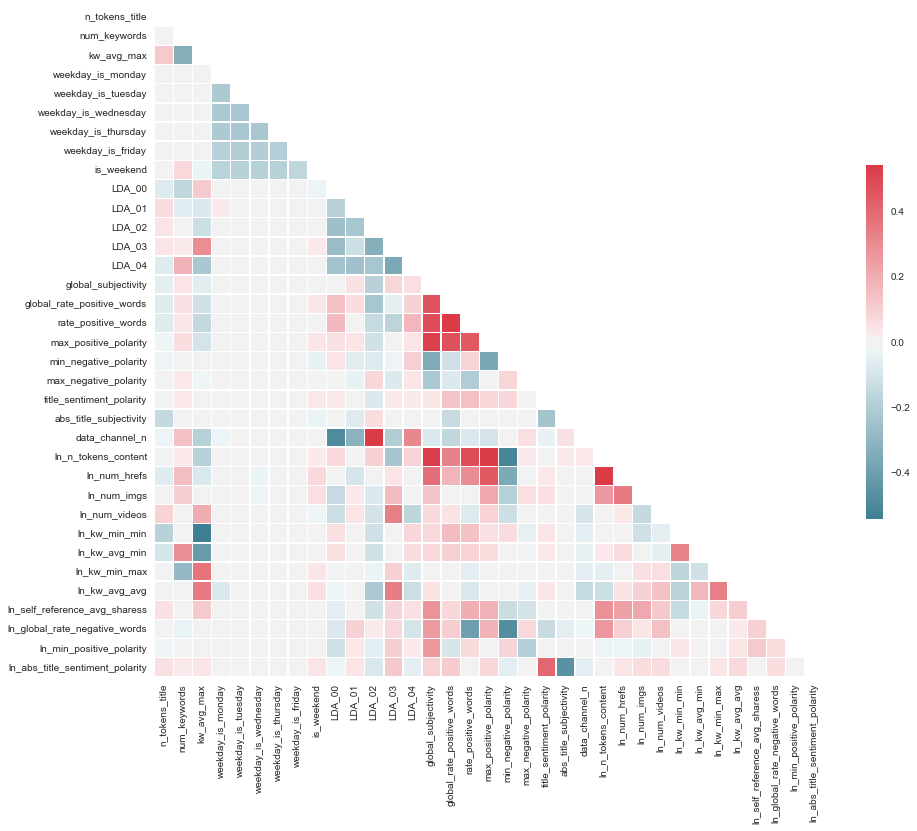

In [17]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


# from example found at https://www.kaggle.com/maheshdadhich/strength-of-visualization-python-visuals-tutorial/notebook

#### Save cleaned / reduced data set to external .csv file  

 - This provides opportunity to just read in this .csv file and no need to repeat data cleaning / reduction process for each execution  
 

In [18]:

df.data_channel.value_counts()
df.describe().T

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... store in ../data/ directory
# ... write as .csv file for future recall
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

data_dir = '../data/'
data_file = 'mashable_clean_dataset_for_lab_02_task_02.csv'

file_2_write = data_dir + data_file

df.to_csv(file_2_write, index = False)


World            8427
Technology       7346
Entertainment    7057
Business         6258
Others           6134
Social Media     2323
Lifestyle        2099
Name: data_channel, dtype: int64

,count,mean,std,min,25%,50%,75%,max
n_tokens_title,39644.0,10.398749,2.114037,2.0,9.000000,10.000000,12.000000,23.000000
num_keywords,39644.0,7.223767,1.909130,1.0,6.000000,7.000000,9.000000,10.000000
kw_avg_max,39644.0,1.913205,1.000000,0.0,1.271003,1.800325,2.442234,6.248298
weekday_is_monday,39644.0,0.168020,0.373889,0.0,0.000000,0.000000,0.000000,1.000000
weekday_is_tuesday,39644.0,0.186409,0.389441,0.0,0.000000,0.000000,0.000000,1.000000
weekday_is_wednesday,39644.0,0.187544,0.390353,0.0,0.000000,0.000000,0.000000,1.000000
weekday_is_thursday,39644.0,0.183306,0.386922,0.0,0.000000,0.000000,0.000000,1.000000
weekday_is_friday,39644.0,0.143805,0.350896,0.0,0.000000,0.000000,0.000000,1.000000
is_weekend,39644.0,0.130915,0.337312,0.0,0.000000,0.000000,0.000000,1.000000
LDA_00,39644.0,0.184599,0.262975,0.0,0.025051,0.033387,0.240958,0.926994


# 	Modeling and Evaluation 2

### Training and test split

In [19]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  copy data frame to classification working data frame
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# ... data set with text categorical target values 

df_data_channel = df.copy()
del df_data_channel['data_channel_n']

# ... data set with integer categorical target values 

df_data_channel_n = df.copy()
del df_data_channel_n['data_channel']

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  separate X and y matrices 
# ...
# ...  convert to numpy matrices by calling 'values' on the pandas data frames
# ...  they are now simple matrices for compatibility with scikit-learn
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

if 'data_channel' in df_data_channel:
    y = df_data_channel['data_channel'].values         # set 'data_channel' as dependent
    del df_data_channel['data_channel']                # remove from dataset
    X = df_data_channel.values                         # use everything else for independent EVs

if 'data_channel_n' in df_data_channel_n:
    y_n = df_data_channel_n['data_channel_n'].values    # set 'data_channel' as dependent
    del df_data_channel_n['data_channel_n']             # remove from dataset
    X_n = df_data_channel_n.values                      # use everything else for independent EVs


# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  dataframe in which to record results of model metrics
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

results_table_labels = ['n_features', 'n_estimate', 'process_time', 'accuracy', 'recall', 'precision', 'f1_score']
df_results = pd.DataFrame(columns = results_table_labels)


# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  setup cross-validation in sklearn
# ...
# ...  split into training and test sets
# ....  --> 10 folds
# ...   --> 80% / 20% training / test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 10

num_instances = len(y)

cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)


ShuffleSplit(n_splits=10, random_state=None, test_size=0.2, train_size=None)


In [20]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  run through the cross validation loop and set the training and testing
# ...  variable for one single iteration
# ...
# ...  --> this method is memory-user, but easier to follow what is being done 
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

for train_indices, test_indices in cv_object.split(X, y): 
    X_train = X[train_indices]
    y_train = y[train_indices]    
    X_test  = X[test_indices]
    y_test  = y[test_indices]
    
    
for train_indices_n, test_indices_n in cv_object.split(X_n, y_n): 
    X_train_n = X_n[train_indices_n]
    y_train_n = y_n[train_indices_n]    
    X_test_n  = X_n[test_indices_n]
    y_test_n  = y_n[test_indices_n]

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... scale attributes by the training set
# ... - normalize features based on mean & stdev of each column
# ... - do not use the testing data
# ... - use what was last stored in the variables: X_train, y_train, X_test, y_test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

scl_obj = StandardScaler()
scl_obj.fit(X_train)                        # scale for each column for (0,1) mean, std
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled  = scl_obj.transform(X_test) 

scl_obj_n = StandardScaler()
scl_obj_n.fit(X_train_n)                        # scale for each column for (0,1) mean, std
    
X_train_n_scaled = scl_obj_n.transform(X_train_n) # apply to training
X_test_n_scaled  = scl_obj_n.transform(X_test_n) 

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [21]:
# set required variables for model comparison

comparison_tbl = pd.DataFrame(columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'])
i_index=[]
i_index = 0

# preparation for cross validation and model comparison, each classifier is appended once model is fit

models = []

# 	Modeling and Evaluation 3	

For task 2 we have chosen the following 4 models:<br>
a. Multinomial logistic regression with parament selection using Grid Search<br>
b. Decision Tree with parament selection using Grid Search<br>
c. Random Forest with parament selection using Grid Search<br>
d. Naive Bayes<br>

Each of these models will be evaluated on Accuracy, Precision, Recall, FScore and Execution time

### a. Multinomial logistic regression
For multinomial LR we have set standard attributes with:
    class_weight = balanced<br>
    multi_class = multinomial<br>
<b>search params:</b><br>
    tolerance parament tol<br>
    Regularization parament C<br>
    
    
#### _Grid selection for logistic regression_

In [22]:
from sklearn.grid_search import GridSearchCV
lr_model = LogisticRegression(class_weight = 'balanced', multi_class = 'multinomial', solver = 'lbfgs', C=10,tol=0.1)
params = {
    'C':[100, 1000], 
    'tol': [0.001, 0.0001]
}
clf = GridSearchCV(lr_model, params, scoring='log_loss', refit='True', n_jobs=-1, cv=5)
grid_search = clf.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

C:\Users\Preeti\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Preeti\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### _Best parameter values for logistic regression_:

In [23]:
best_accuracy
best_parameters

-0.7512350584442264

{'C': 1000, 'tol': 0.001}

#### Create main logistic model using best paraments for further analysis and model comparisons

In [24]:
tic = time.clock()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... basic multiclass Logistic Regression
# ... - normalize features based on mean & stdev of each column
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

lr_model1 = LogisticRegression(class_weight = 'balanced', multi_class = 'multinomial', solver = 'lbfgs',C= 1000, tol= 0.001)
lr_model1.fit(X_train_scaled, y_train)  # train object
y_hat = lr_model1.predict(X_test_scaled) # get test set precitions

toc =  time.clock()

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_hat))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_hat,average='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_hat,average='weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_hat,average='weighted'))

exetime = '{0:.4f}'.format(toc-tic)

# print statistics

print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", conf(y_test, y_hat))
print('process time',exetime)
print("\n")

# save statistics for model comparison

raw_data = {
    'Model Name':'Logistic Regression',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}
df = pd.DataFrame(raw_data,columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],index=[i_index+1])
comparison_tbl = comparison_tbl.append(df)

#append model classifier for cross-validation

models.append(('Logistic Regression',lr_model1))

LogisticRegression(C=1000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.001, verbose=0,
          warm_start=False)

accuracy 0.7330
precision 0.7629
recall 0.7330
f1_score 0.7448
confusion matrix
 [[ 941   28   55    9  144   55   20]
 [  12 1084   35  193   51   19   34]
 [  26    8  207   28   35  104   10]
 [   3  156   34  947   36    3   12]
 [  82   29   51   24  205   23   31]
 [  31   15  302    2   29 1003   77]
 [  16   48   41   20   90   96 1425]]
process time 1.8104




### b. Decision Tree Classifier using Grid Search
#### _Grid search parameter set-up_

In [25]:
# Applying Grid Search to find the best model and the best parameters
from sklearn.tree import DecisionTreeClassifier
DTclassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
from sklearn.model_selection import GridSearchCV
parameters = [
      {
        'criterion': ['gini'], 
        'max_depth': [None], 
        'min_samples_split': [2, 100, 1000], 
        'min_samples_leaf': [1, 10, 100],
        'max_features': [None], 'max_leaf_nodes': [None]
      },
      {
          'criterion': ['entropy'], 
          'max_depth': [None, 5, 10], 
          'min_samples_split': [2, 100, 1000],
          'min_samples_leaf': [1, 10, 100], 
          'max_leaf_nodes': [None]
      }
     ]
grid_search = GridSearchCV(estimator = DTclassifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 2,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

#### _Best parameters for Decision Tree_

In [27]:
best_accuracy
best_parameters

0.76922591833517262

{'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 10,
 'min_samples_split': 100}

#### _use best parameters to create best Decision Tree model for further analysis and model comparison_

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report
tic = time.clock()

# train and fit
DTclassifier = DecisionTreeClassifier(criterion = 'gini',min_samples_leaf=10,min_samples_split=100)
DTclassifier.fit(X_train, y_train)
y_predDT = DTclassifier.predict(X_test)

# calculate statistics
accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predDT))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predDT,average='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predDT,average='weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predDT,average='weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predDT))
print('process time',exetime)
print("\n")

# save statistics for model comparison
raw_data = {
    'Model Name':'Decision Tree Classifier',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}
df = pd.DataFrame(raw_data,columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],index=[i_index+1])
comparison_tbl = comparison_tbl.append(df)

#append model classifier for cross-validation
models.append(('Decision Tree Classifier',DTclassifier))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

accuracy 0.7635
precision 0.7520
recall 0.7635
f1_score 0.7550
confusion matrix
 [[1040   30   18    6   48   72   38]
 [  20 1098    5  207   16   39   43]
 [  48   20  108   39   15  175   13]
 [  15  191   14  928   10   12   21]
 [ 105   52   21   25  155   46   41]
 [  34   20   76    7   12 1208  102]
 [  26   60   10   15   32   76 1517]]
process time 0.9713




### c. Random Forest Classifier

#### _Grid Search parameter set-up for Random Forest classifier_

In [29]:
RFclf = RandomForestClassifier(criterion = 'entropy', max_features= 'sqrt',max_depth = 50, n_estimators = 10, n_jobs = -1)
#RFclf.fit(X_train, y_train)
param_grid =[
    { 
    'criterion': ['gini'],
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
     'max_depth': [20,50,100]
},
 { 
    'criterion': ['entropy'],
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
     'max_depth': [20,50,100]
}
]
RF_grid_search = GridSearchCV(estimator=RFclf, param_grid=param_grid, cv= 2)
grid_search = RF_grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

#### _best parameters for Random Forest Classifier_

In [30]:
best_accuracy
best_parameters

0.80378369856534759

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'sqrt',
 'n_estimators': 700}

#### _using best parameters for main model for further analysis and model comparison_

In [31]:
from sklearn.ensemble import RandomForestClassifier

tic = time.clock()

# train and test 

RFclf = RandomForestClassifier(criterion = 'entropy', max_depth = 20,max_features= 'sqrt', n_estimators = 700, n_jobs = -1)
RFclf.fit(X_train, y_train)
y_predRF = RFclf.predict(X_test)


# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predRF))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predRF, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predRF, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predRF, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predRF))
print('process time',exetime)
print("\n")


# save statistics for model comparison
raw_data = {
    'Model Name':'Random Forest Classifier',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}
df = pd.DataFrame(raw_data,columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],index=[i_index+1])
comparison_tbl = comparison_tbl.append(df)

#append model classifier for cross-validation
models.append(('Random Forest Classifier',RFclf))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=700, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

accuracy 0.8167
precision 0.8169
recall 0.8167
f1_score 0.7992
confusion matrix
 [[1126   27    0    6    4   59   30]
 [  22 1171    2  162    3   37   31]
 [  52    8   50   41   11  245   11]
 [  10   70    5 1082    2    8   14]
 [ 103   42    4   24  186   48   38]
 [  40   15    8    4    4 1313   75]
 [  33   34    1   27   12   81 1548]]
process time 50.1402




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=700, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


<Container object of 34 artists>

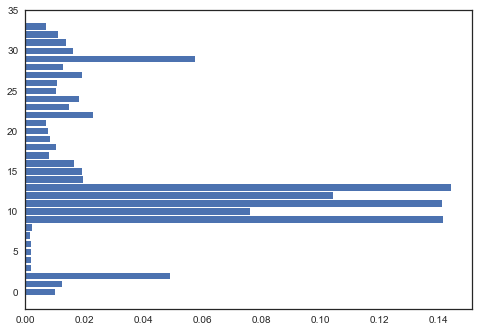

In [32]:
print (RFclf)
plt.barh(range(len(RFclf.feature_importances_)), RFclf.feature_importances_)
plt.show()

#  3: Naive Bayes ***


In [33]:
from sklearn.naive_bayes import MultinomialNB

clf_mnb = MultinomialNB(alpha = 1.0, class_prior = None, fit_prior = True)

clf_mnb.fit(X_train_n, y_train_n)

print('\n class counts') 
print (clf_mnb.class_count_)
print('\n class prior prob (log)')
print (clf_mnb.class_log_prior_)

print('\n\n\n feature counts') 
print (clf_mnb.feature_count_)
print('\n feature prob (log)')
print (clf_mnb.feature_log_prob_)

y_hatm = clf_mnb.predict(X_test_n)
    
accm = mt.accuracy_score(y_test_n, y_hatm)
    
print('MultinomialNB Naïve Bayes Accuracy :', accm) 

# ... confusion matrix

cm_nb = confusion_matrix(y_test_n, y_hatm)
print(cm_nb)


ImportError: cannot import name 'logsumexp'

In [144]:
from sklearn.naive_bayes import GaussianNB

clf_gnb = GaussianNB()

clf_gnb.fit(X_train_n, y_train_n)

y_hatm = clf_gnb.predict(X_test_n)
    
accm = mt.accuracy_score(y_test_n, y_hatm)
    
print('Gaussian Naïve Bayes Accuracy :', accm) 

# ... confusion matrix

cm_gnb = confusion_matrix(y_test_n, y_hatm)
print(cm_gnb)


GaussianNB(priors=None)

Gaussian Naïve Bayes Accuracy : 0.70639424896
[[1026   25   29    9   87   70   25]
 [  17  986   19  268   33   21   27]
 [  60    7   83   28   17  235   16]
 [   4  215   45  917   43    3    6]
 [ 198   40   31   47   83   29   66]
 [  45   21  129    3   13 1155   99]
 [  29   62   13   27   58  109 1351]]


#	Modeling and Evaluation 4

In [34]:
# converting acc, pre, recall, fscore and time to numeric values for plots
comparison_tbl = comparison_tbl.reset_index(drop=True)
comparison_tbl['Precision'] =pd.to_numeric(comparison_tbl['Precision'])
comparison_tbl['Accuracy']= pd.to_numeric(comparison_tbl['Accuracy'])
comparison_tbl['FScore']= pd.to_numeric(comparison_tbl['FScore'])
comparison_tbl['Processing Time'] = pd.to_numeric(comparison_tbl['Processing Time'])
comparison_tbl['Recall']= pd.to_numeric(comparison_tbl['Recall'])
comparison_tbl

,Model Name,Accuracy,Precision,Recall,FScore,Processing Time
0,Logistic Regression,0.7330,0.7629,0.7330,0.7448,1.8104
1,Decision Tree Classifier,0.7635,0.7520,0.7635,0.7550,0.9713
2,Random Forest Classifier,0.8167,0.8169,0.8167,0.7992,50.1402


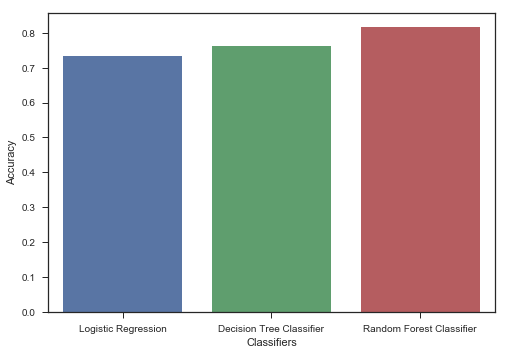

In [35]:
comparison_tbl.plot()
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 8, 5
sns.set(style="ticks")
sns.barplot(data=comparison_tbl,y='Accuracy',x='Model Name')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.show()

# Cross-Validation

In [36]:
from sklearn import model_selection
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	cv_results = model_selection.cross_val_score(model,X_train_scaled, y_train, cv=10, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

Logistic Regression: 0.746019 (0.006700)
Decision Tree Classifier: 0.767051 (0.008579)
Random Forest Classifier: 0.812076 (0.006247)


{'boxes': [<matplotlib.lines.Line2D at 0x1c21ad2e2b0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c21ad2f748>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c21ad24748>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1c21ad33c50>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1c21ad2efd0>,
  <matplotlib.lines.Line2D at 0x1c21ad28a20>]}

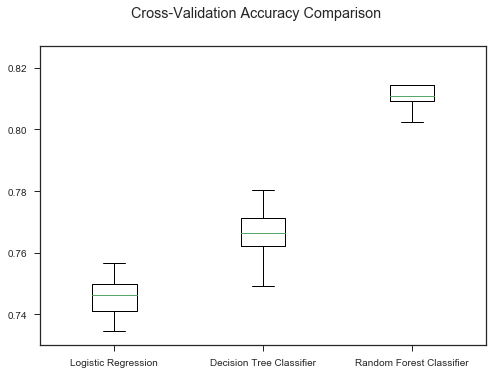

In [37]:
# boxplot accuracy comparison
fig = plt.figure()
fig.suptitle('Cross-Validation Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# 	Exceptional Work	
We have implemented Grid search in our parament selection process.